In [13]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path
from scipy.stats import chi2_contingency

## Relevant functions from utils.py

In [14]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df

def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

## Load hmc samples

In [16]:
# Get interval corresponding to one in paper
df = index_mcmc_runs(file_version='2023')
print(df.shape)

# Find negative polarity interval measured by AMS02_h... in 20130221-20130319
interval = '20130221-20130319'
df_int = df[df.interval == interval]
idx = df_int.index[0]
polarity = df_int.polarity.iloc[0]
exp_name = df_int.experiment_name.iloc[0]
print(f"Interval {interval} corresponds to index {idx} for {polarity} polarity in {exp_name}.")
df_int.head()

(133, 12)
Interval 20130221-20130319 corresponds to index 24 for neg polarity in AMS02_H-PRL2021.


,interval,alpha,cmf,vspoles,alpha_std,cmf_std,vspoles_std,beginning,ending,polarity,experiment_name,filename_heliosphere
24,20130221-20130319,70.0,5.59,490.68,4.66,2.57,21.79,2013-02-21,2013-02-21,neg,AMS02_H-PRL2021,../../data/2023/AMS02_H-PRL2021_heliosphere.dat


In [26]:
# Load results from HMC run
# results_dir_hmc = f'../../../results/v26/fulldataset'
results_dir_hmc = f'../../../results/v26/0.001'
num_results = 110_000

# Load the samples from each hmc run
# They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
# csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples = pd.read_csv(f'{results_dir_hmc}.0/samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_1_samples = pd.read_csv(f'{results_dir_hmc}.1/samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

hmc_0_samples.columns = ['cpa', 'pwr1par', 'pwr1perp', 'pwr2par', 'pwr2perp']
hmc_1_samples.columns = ['cpa', 'pwr1par', 'pwr1perp', 'pwr2par', 'pwr2perp']

print(hmc_0_samples.head())
print(hmc_1_samples.head())

          cpa   pwr1par  pwr1perp   pwr2par  pwr2perp
0  483.183075  0.847570  1.200870  0.547127  0.934379
1  488.362823  0.850093  1.208489  0.563209  0.920270
2  477.961121  0.850015  1.211233  0.592906  0.925046
3  479.597260  0.842089  1.227659  0.564355  0.910315
4  474.951141  0.803839  1.192150  0.565206  0.927021
          cpa   pwr1par  pwr1perp   pwr2par  pwr2perp
0  476.081116  0.841148  1.198994  0.564117  0.925101
1  481.659088  0.841468  1.210214  0.564644  0.929357
2  476.678589  0.820821  1.203361  0.567462  0.911580
3  481.716492  0.823453  1.211637  0.558245  0.931183
4  486.096710  0.845767  1.218688  0.542800  0.912958


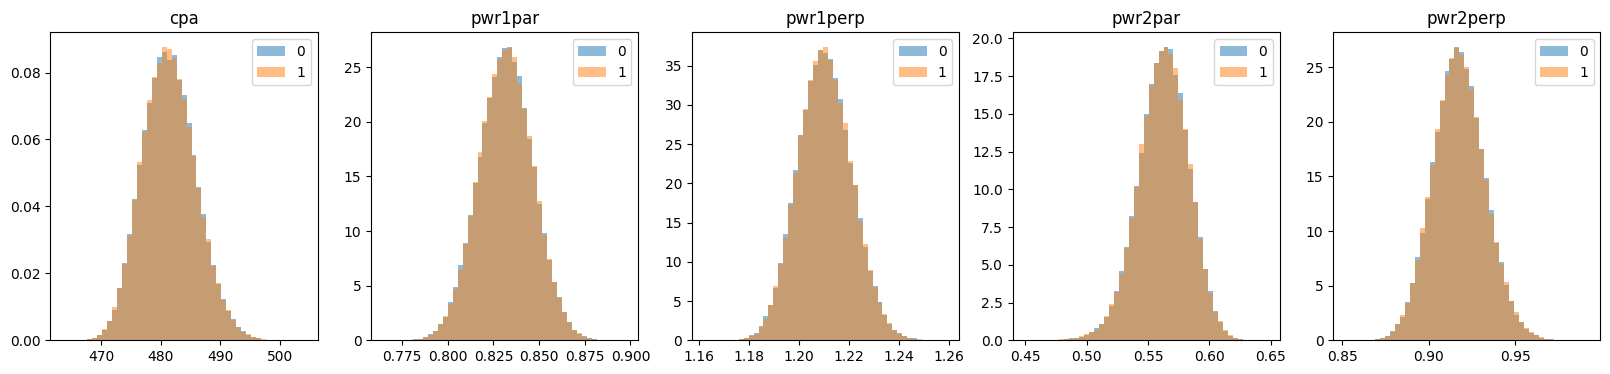

In [27]:
# Let's make a 1 x 5 grid of subplots, where they are the historograms of the samples. We'll plot both hmc_0 and hmc_1 samples in the same grid
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# Plot the samples
for i, param in enumerate(['cpa', 'pwr1par', 'pwr1perp', 'pwr2par', 'pwr2perp']):
    samples_0 = hmc_0_samples[param].values
    samples_1 = hmc_1_samples[param].values

    # Plot the samples with same bins
    total_list = np.concatenate((samples_0, samples_1), axis=0)
    min = np.min(total_list)
    max = np.max(total_list)
    bins = np.linspace(min, max, 50)

    axs[i].hist(samples_0, bins=bins, density=True, alpha=0.5, label='0')
    axs[i].hist(samples_1, bins=bins, density=True, alpha=0.5, label='1')

    # Set the title and labels
    axs[i].set_title(param)
    axs[i].legend(loc='upper right')

plt.show()

In [42]:
# Calculate the Chi-Squared test of Homogeneity between hmc_0_samples and hmc_1_samples
def chi2_test_of_homogeneity(df1, df2, num_bins=10):
    results = {}

    for col in df1.columns:
        # Define bin edges based on combined data to ensure same binning
        combined_data = np.concatenate([df1[col], df2[col]])
        bins = np.linspace(combined_data.min(), combined_data.max(), num_bins + 1)

        # Bin both datasets
        df1_binned = np.digitize(df1[col], bins) - 1
        df2_binned = np.digitize(df2[col], bins) - 1

        # Create contingency table
        contingency_table = np.array([
            np.bincount(df1_binned, minlength=num_bins),
            np.bincount(df2_binned, minlength=num_bins)
        ])

        # Perform chi-square test
        chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

        results[col] = {'chi2_stat': chi2_stat, 'p_value': p_value}
    
    return results

# Run the test
results = chi2_test_of_homogeneity(hmc_0_samples, hmc_1_samples)

# Display results
for col, res in results.items():
    print(f"Column: {col}, Chi2 Statistic: {res['chi2_stat']:.4f}, p-value: {res['p_value']:.4e}")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.